#   DS-INTERN-TESLA STOCK PRICE PREDICTION
    
### Y SANTHI SWARUP
   
     ysswarup18@gmail.com
   
#### Datasets used
-  Nasdaq:  https://www.nasdaq.com/
-  Xignite: https://www.xignite.com/

   

### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [2]:
df = pd.read_csv('HistoricalData_TSLA.csv',parse_dates = ["Date"], index_col = "Date")
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-06-09,$598.78,16584570,$602.17,$611.79,$597.6301
2021-06-08,$603.59,26053410,$623.01,$623.09,$595.5
2021-06-07,$605.13,22543680,$591.825,$610,$582.88
2021-06-04,$599.05,24036900,$579.71,$600.61,$577.2
2021-06-03,$572.84,30111890,$601.8,$604.55,$571.22


In [3]:
df_headlines = pd.read_csv('Headlines_2021.csv',parse_dates = ["Date"], index_col = "Date")
df_headlines.head()

,Headlines
Date,
2021-01-01,Tales of underage workers in Apple&quot;s supp...
2021-01-02,Why Apple &quot;iCar&quot; Won&quot;t Be Self-...
2021-01-03,The best after-Christmas deals you can get rig...
2021-01-04,How four of this year&quot;s Transformers help...
2021-01-05,The Apple Products That Could Be Released In 2...


In [4]:
df.isnull().sum()

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [5]:
df_headlines.isnull().sum()

Headlines    0
dtype: int64

In [6]:
sum(df.duplicated())

0

In [7]:
sum(df_headlines.duplicated())

1

In [8]:
df_headlines = df_headlines.drop_duplicates()
sum(df_headlines.duplicated())

0

In [9]:
len(df), len(df_headlines)

(2516, 173)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2021-06-09 to 2011-06-10
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Close/Last  2516 non-null   object
 1   Volume      2516 non-null   int64 
 2   Open        2516 non-null   object
 3   High        2516 non-null   object
 4   Low         2516 non-null   object
dtypes: int64(1), object(4)
memory usage: 117.9+ KB


### Changing the Dtype

In [11]:
df['Open']=df['Open'].str.replace('$','').astype(float)


In [12]:
df['Close/Last']=df['Close/Last'].str.replace('$','').astype(float)

In [13]:
df['High']=df['High'].str.replace('$','').astype(float)

In [14]:
df['Low']=df['Low'].str.replace('$','').astype(float)
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-06-09,598.78,16584570,602.170,611.79,597.6301
2021-06-08,603.59,26053410,623.010,623.09,595.5000
2021-06-07,605.13,22543680,591.825,610.00,582.8800
2021-06-04,599.05,24036900,579.710,600.61,577.2000
2021-06-03,572.84,30111890,601.800,604.55,571.2200


### Combined Stock Data

In [15]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([df, df_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close/Last,Volume,Open,High,Low,Headlines
Date,,,,,,
2021-01-04,729.77,48638190.0,719.460,744.4899,717.1895,How four of this year&quot;s Transformers help...
2021-01-05,735.11,32245170.0,723.660,740.8400,719.2000,The Apple Products That Could Be Released In 2...
2021-01-06,755.98,44699970.0,758.490,774.0000,749.1000,"TSX nears record high as cannabis, renewables ..."
2021-01-07,816.04,51498950.0,777.630,816.9900,775.2000,Apple&quot;s Self-Driving Electric Car Is At L...
2021-01-08,880.02,75055530.0,856.000,884.4900,838.3900,Apple Threatens to Ban Parler From App Store A...
...,...,...,...,...,...,...
2021-06-03,572.84,30111890.0,601.800,604.5500,571.2200,Buy RH Stock on the Dip Before Q1 Earnings for...
2021-06-04,599.05,24036900.0,579.710,600.6100,577.2000,"Global equities nearly grasp all-time record, ..."
2021-06-07,605.13,22543680.0,591.825,610.0000,582.8800,Apple&quot;s new &quot;private relay&quot; fea...


### Calculating Sentiment Scores

In [16]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close/Last,Volume,Open,High,Low,Headlines,compound,negative,neutral,positive
Date,,,,,,,,,,
2021-01-04,729.77,48638190.0,719.46,744.4899,717.1895,How four of this year&quot;s Transformers help...,,,,
2021-01-05,735.11,32245170.0,723.66,740.8400,719.2000,The Apple Products That Could Be Released In 2...,,,,
2021-01-06,755.98,44699970.0,758.49,774.0000,749.1000,"TSX nears record high as cannabis, renewables ...",,,,
2021-01-07,816.04,51498950.0,777.63,816.9900,775.2000,Apple&quot;s Self-Driving Electric Car Is At L...,,,,
2021-01-08,880.02,75055530.0,856.00,884.4900,838.3900,Apple Threatens to Ban Parler From App Store A...,,,,


In [17]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata


# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['Headlines'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close/Last,Volume,Open,High,Low,Headlines,compound,negative,neutral,positive
Date,,,,,,,,,,
2021-01-04,729.77,48638190.0,719.46,744.4899,717.1895,How four of this year&quot;s Transformers help...,0.9931,0.053,0.816,0.130
2021-01-05,735.11,32245170.0,723.66,740.8400,719.2000,The Apple Products That Could Be Released In 2...,0.9981,0.015,0.876,0.109
2021-01-06,755.98,44699970.0,758.49,774.0000,749.1000,"TSX nears record high as cannabis, renewables ...",0.9976,0.046,0.836,0.118
2021-01-07,816.04,51498950.0,777.63,816.9900,775.2000,Apple&quot;s Self-Driving Electric Car Is At L...,0.9896,0.056,0.839,0.105
2021-01-08,880.02,75055530.0,856.00,884.4900,838.3900,Apple Threatens to Ban Parler From App Store A...,0.9682,0.055,0.864,0.081


### Finalising Stock Data and writing to Disk

In [18]:
# dropping the 'headlines' which is unwanted now
stock_data.drop(['Headlines'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close/Last', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-01-04,729.77,0.9931,0.053,0.816,0.130,719.46,744.4899,717.1895,48638190.0
2021-01-05,735.11,0.9981,0.015,0.876,0.109,723.66,740.8400,719.2000,32245170.0
2021-01-06,755.98,0.9976,0.046,0.836,0.118,758.49,774.0000,749.1000,44699970.0
2021-01-07,816.04,0.9896,0.056,0.839,0.105,777.63,816.9900,775.2000,51498950.0
2021-01-08,880.02,0.9682,0.055,0.864,0.081,856.00,884.4900,838.3900,75055530.0


In [19]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

### Reading Stock Data

In [20]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-01-04,729.77,0.9931,0.053,0.816,0.130,719.46,744.4899,717.1895,48638190.0
2021-01-05,735.11,0.9981,0.015,0.876,0.109,723.66,740.8400,719.2000,32245170.0
2021-01-06,755.98,0.9976,0.046,0.836,0.118,758.49,774.0000,749.1000,44699970.0
2021-01-07,816.04,0.9896,0.056,0.839,0.105,777.63,816.9900,775.2000,51498950.0
2021-01-08,880.02,0.9682,0.055,0.864,0.081,856.00,884.4900,838.3900,75055530.0


### Feature Engineering of Stock Data

In [21]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(108, 9)

In [22]:
# checking for null values
stock_data.isna().any()

Close/Last    False
compound      False
negative      False
neutral       False
positive      False
Open          False
High          False
Low           False
Volume        False
dtype: bool

In [23]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,1.080000e+02
mean,709.908333,0.932681,0.048593,0.848546,0.102861,711.421463,729.658101,692.798233,3.333698e+07
std,92.314082,0.310957,0.017023,0.027334,0.022686,91.431375,93.526313,91.929382,1.275869e+07
min,563.000000,-0.996500,0.015000,0.776000,0.044000,552.550000,566.210000,539.490000,1.515765e+07
25%,630.705000,0.984125,0.035750,0.826000,0.086000,638.527500,654.297500,618.302500,2.538529e+07
50%,692.675000,0.993800,0.046500,0.850000,0.103500,697.905000,708.330000,674.412500,3.065650e+07
75%,794.202500,0.997400,0.058250,0.868250,0.116000,784.425000,818.247500,776.545000,3.907411e+07
max,883.090000,0.999200,0.098000,0.908000,0.157000,891.380000,900.400000,871.600000,8.939646e+07


In [24]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 2021-01-04 to 2021-06-09
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  108 non-null    float64
 1   compound    108 non-null    float64
 2   negative    108 non-null    float64
 3   neutral     108 non-null    float64
 4   positive    108 non-null    float64
 5   Open        108 non-null    float64
 6   High        108 non-null    float64
 7   Low         108 non-null    float64
 8   Volume      108 non-null    float64
dtypes: float64(9)
memory usage: 8.4+ KB


Text(0, 0.5, 'Close Price ($)')

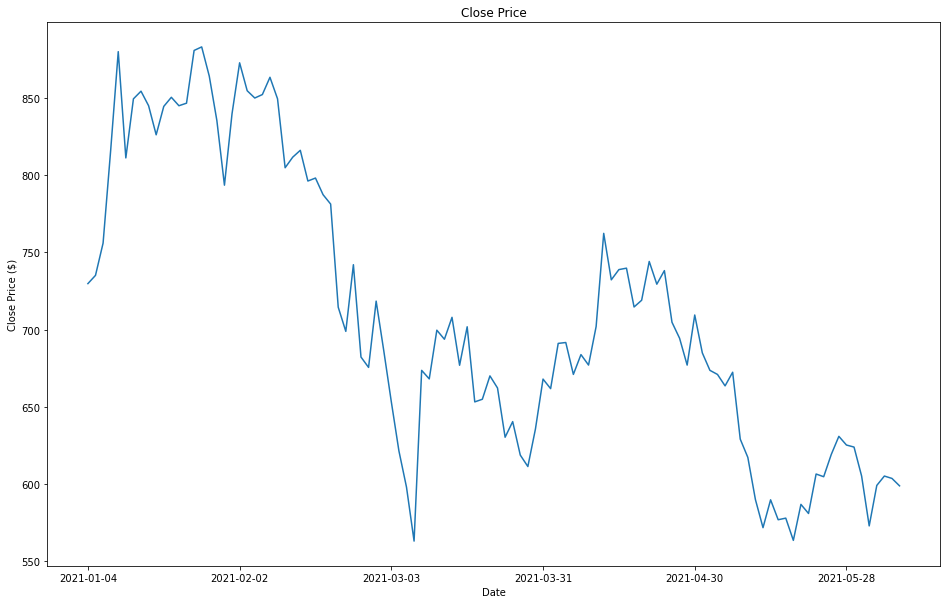

In [25]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close/Last'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [26]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-12,796.792857,0.991671,0.048143,0.830714,0.121143,787.948571,811.891414,775.720243,5.113753e+07
2021-01-13,814.598571,0.991900,0.046857,0.835571,0.117714,806.991429,828.460000,792.121743,4.894814e+07
2021-01-14,830.297143,0.991900,0.049143,0.831000,0.120000,824.095714,845.911429,809.200314,4.880831e+07


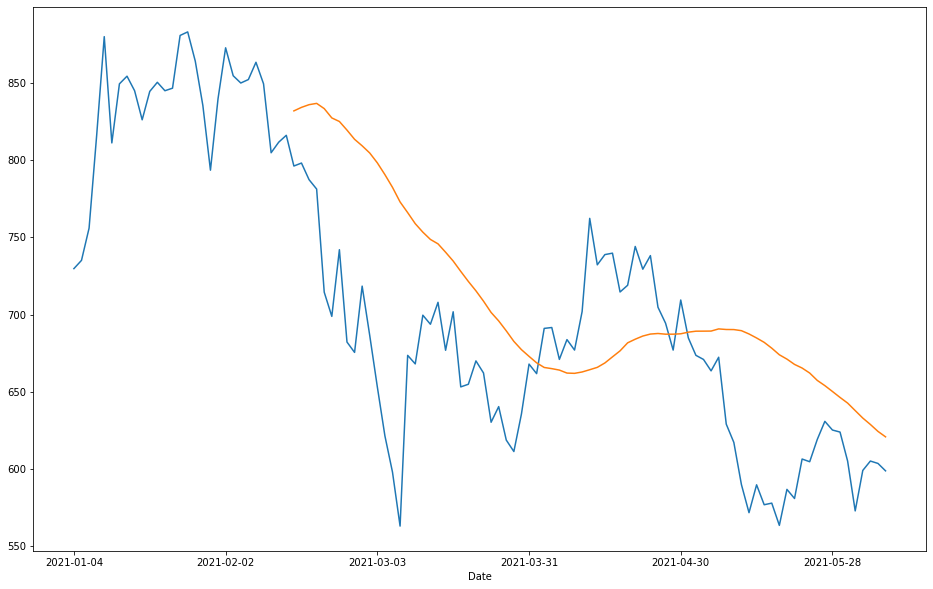

In [27]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close/Last'].plot()
stock_data.rolling(window=30).mean()['Close/Last'].plot()

In [28]:
# displaying stock_data
stock_data

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2021-01-04,729.77,0.9931,0.053,0.816,0.130,719.460,744.4899,717.1895,48638190.0
2021-01-05,735.11,0.9981,0.015,0.876,0.109,723.660,740.8400,719.2000,32245170.0
2021-01-06,755.98,0.9976,0.046,0.836,0.118,758.490,774.0000,749.1000,44699970.0
2021-01-07,816.04,0.9896,0.056,0.839,0.105,777.630,816.9900,775.2000,51498950.0
2021-01-08,880.02,0.9682,0.055,0.864,0.081,856.000,884.4900,838.3900,75055530.0
...,...,...,...,...,...,...,...,...,...
2021-06-03,572.84,0.9933,0.043,0.869,0.088,601.800,604.5500,571.2200,30111890.0
2021-06-04,599.05,0.9942,0.024,0.901,0.075,579.710,600.6100,577.2000,24036900.0
2021-06-07,605.13,0.9981,0.020,0.885,0.095,591.825,610.0000,582.8800,22543680.0


### Data Preparation for Modelling

In [29]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 85
Number of records in Test Data: 23


In [30]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2021-01-05    735.11
2021-01-06    755.98
2021-01-07    816.04
2021-01-08    880.02
2021-01-11    811.19
               ...  
2021-06-03    572.84
2021-06-04    599.05
2021-06-07    605.13
2021-06-08    603.59
2021-06-09    598.78
Name: Close/Last, Length: 107, dtype: float64

In [31]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2021-01-05,735.11,755.98,0.9981,0.9976,32245170.0,723.66,740.84,719.2000
2021-01-06,755.98,816.04,0.9976,0.9896,44699970.0,758.49,774.00,749.1000
2021-01-07,816.04,880.02,0.9896,0.9682,51498950.0,777.63,816.99,775.2000
2021-01-08,880.02,811.19,0.9682,0.9977,75055530.0,856.00,884.49,838.3900
2021-01-11,811.19,849.44,0.9977,0.9974,59554150.0,849.40,854.43,803.6222
2021-01-12,849.44,854.41,0.9974,0.9947,46270720.0,831.00,868.00,827.3400
2021-01-13,854.41,845.00,0.9947,0.9981,33312500.0,852.76,860.47,832.0000
2021-01-14,845.00,826.16,0.9981,0.9924,31266330.0,843.39,863.00,838.7500
2021-01-15,826.16,844.55,0.9924,0.9958,38777600.0,852.00,859.90,819.1000


### Setting the Target Variable and the Feature Dataset

In [32]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2021-01-05    755.98
2021-01-06    816.04
2021-01-07    880.02
2021-01-08    811.19
2021-01-11    849.44
               ...  
2021-06-02    572.84
2021-06-03    599.05
2021-06-04    605.13
2021-06-07    603.59
2021-06-08    598.78
Name: close_price_shifted, Length: 106, dtype: float64

In [33]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2021-01-05,735.11,0.9981,0.9976,32245170.0,723.660,740.84,719.2000
2021-01-06,755.98,0.9976,0.9896,44699970.0,758.490,774.00,749.1000
2021-01-07,816.04,0.9896,0.9682,51498950.0,777.630,816.99,775.2000
2021-01-08,880.02,0.9682,0.9977,75055530.0,856.000,884.49,838.3900
2021-01-11,811.19,0.9977,0.9974,59554150.0,849.400,854.43,803.6222
...,...,...,...,...,...,...,...
2021-06-02,605.12,0.9898,0.9933,23302780.0,620.130,623.36,599.1400
2021-06-03,572.84,0.9933,0.9942,30111890.0,601.800,604.55,571.2200
2021-06-04,599.05,0.9942,0.9981,24036900.0,579.710,600.61,577.2000


### Scaling the Target Variable and the Feature Dataset

Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.

In [34]:
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [35]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[ 0.07538505,  0.99889763,  0.99839655, -0.53966072,  0.01000502,
          0.04509411,  0.08223179],
        [ 0.20578587,  0.99839655,  0.99037932, -0.20412733,  0.21559484,
          0.24354409,  0.26229261],
        [ 0.58105533,  0.99037932,  0.96893321, -0.02096222,  0.32857185,
          0.50082289,  0.41946945],
        [ 0.98081789,  0.96893321,  0.99849677,  0.6136541 ,  0.79116371,
          0.9047847 ,  0.80000602],
        [ 0.55075135,  0.99849677,  0.99819612,  0.19604557,  0.75220612,
          0.72488704,  0.59063082],
        [ 0.78974663,  0.99819612,  0.9954903 , -0.16181119,  0.64359708,
          0.80609833,  0.7334618 ],
        [ 0.8208004 ,  0.9954903 ,  0.99889763, -0.51090676,  0.77203908,
          0.76103414,  0.7615248 ],
        [ 0.76200444,  0.99889763,  0.99318535, -0.56603076,  0.7167311 ,
          0.77617523,  0.80217398],
        [ 0.64428754,  0.99318535,  0.99659267, -0.36367649,  0.76755305,
          0.75762291,  0.68383969],
        [ 

### Dividing the dataset into Training and Test

In [36]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (85, 7) and y: (85, 1)
Number of rows and columns in the Test set X: (20, 7) and y: (20, 1)


### Reshaping the Feature Dataset

In [37]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (85, 7, 1)
Shape of Test set X: (20, 7, 1)


### Stock Data Modelling

In [38]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

In [39]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [40]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
9/9 [==============================] - 17s 596ms/step - loss: 0.2929 - val_loss: 0.1618
Epoch 2/10
9/9 [==============================] - 0s 31ms/step - loss: 0.2393 - val_loss: 0.0812
Epoch 3/10
9/9 [==============================] - 0s 37ms/step - loss: 0.1474 - val_loss: 0.0199
Epoch 4/10
9/9 [==============================] - 0s 35ms/step - loss: 0.0874 - val_loss: 0.0162
Epoch 5/10
9/9 [==============================] - 0s 32ms/step - loss: 0.1382 - val_loss: 0.0391
Epoch 6/10
9/9 [==============================] - 0s 30ms/step - loss: 0.1147 - val_loss: 0.0282
Epoch 7/10
9/9 [==============================] - 0s 27ms/step - loss: 0.1063 - val_loss: 0.0270
Epoch 8/10
9/9 [==============================] - 0s 27ms/step - loss: 0.0994 - val_loss: 0.0247
Epoch 9/10
9/9 [==============================] - 0s 27ms/step - loss: 0.1310 - val_loss: 0.0167
Epoch 10/10
9/9 [==============================] - 0s 27ms/step - loss: 0.1024 - val_loss: 0.0164


### Saving the Model to disk 

In [41]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


### Prediction

In [42]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[661.18024],
       [642.71576],
       [641.20874],
       [639.2403 ],
       [633.8477 ]], dtype=float32)

In [43]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

20/20 [==============================] - 0s 4ms/step - loss: 0.0937
Train Loss = 0.087
Test Loss = 0.0937


In [44]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 643.5488


### Plotting the Prediction

In [45]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

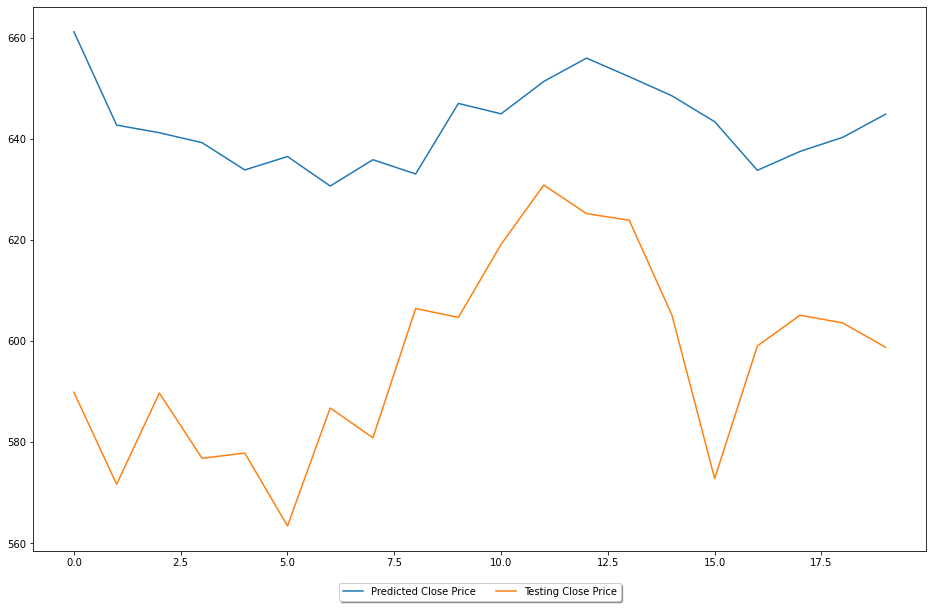

In [46]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

### Reference

https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/